In [1]:
import numpy as np
import tensorflow as tf
import vgg16
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
from tqdm import trange

In [2]:
sess = tf.Session()

In [3]:
with tf.device('/gpu:0'):
    opt_img = tf.Variable( tf.truncated_normal( [1,224,224,3],
                                            dtype=tf.float32,
                                            stddev=1e-1), name='opt_img' )

    tmp_img = tf.clip_by_value( opt_img, 0.0, 255.0 )

    vgg = vgg16.vgg16( tmp_img, 'vgg16_weights.npz', sess )

    style_img = imread( 'style.png', mode='RGB' )
    style_img = imresize( style_img, (224, 224) )
    style_img = np.reshape( style_img, [1,224,224,3] )

    content_img = imread( 'content.png', mode='RGB' )
    content_img = imresize( content_img, (224, 224) )
    content_img = np.reshape( content_img, [1,224,224,3] )

    layers = [ 'conv1_1', 'conv1_2',
               'conv2_1', 'conv2_2',
               'conv3_1', 'conv3_2', 'conv3_3',
               'conv4_1', 'conv4_2', 'conv4_3',
               'conv5_1', 'conv5_2', 'conv5_3' ]

    ops = [ getattr( vgg, x ) for x in layers ]

    content_acts = sess.run( ops, feed_dict={vgg.imgs: content_img } )
    style_acts = sess.run( ops, feed_dict={vgg.imgs: style_img} )

In [4]:
layer = 'conv4_2'
c_loss = tf.reduce_sum(tf.square(getattr(vgg, layer) - content_acts[layers.index(layer)])) / 2

In [5]:
def calc_gram(feat, N, M):
    feat_t = tf.reshape(feat, (M, N))
    return tf.matmul(tf.transpose(feat_t), feat_t)

In [6]:
def s_loss_layer(layer_name):
    layer = tf.squeeze(getattr(vgg, layer_name))
    N = layer.get_shape()[2].value
    M = layer.get_shape()[0].value * layer.get_shape()[1].value
    denom = 4. * N**2 * M**2
    style_act = style_acts[layers.index(layer_name)]
    gram_gen = calc_gram(layer, N, M)
    gram_style = calc_gram(style_act, N, M)
    ret = tf.reduce_sum(tf.square(gram_gen - gram_style)) / denom
    return ret

In [7]:
loss_layers = [
    'conv1_1',
    'conv2_1',
    'conv3_1',
    'conv4_1',
    'conv5_1'
]
s_loss = tf.reduce_sum([s_loss_layer(name) / len(loss_layers) for name in loss_layers])

In [8]:
alpha = 1
beta = 1000

In [9]:
loss = alpha * c_loss + beta * s_loss

In [10]:
lr = tf.placeholder(tf.float16)
train_step = tf.train.AdamOptimizer(lr).minimize(loss, var_list=[opt_img])

In [11]:
# Relevant snippets from the paper:
#   For the images shown in Fig 2 we matched the content representation on layer 'conv4_2'
#   and the style representations on layers 'conv1_1', 'conv2_1', 'conv3_1', 'conv4_1' and 'conv5_1'
#   The ratio alpha/beta was  1x10-3
#   The factor w_l was always equal to one divided by the number of active layers (ie, 1/5)

# --- place your adam optimizer call here
#     (don't forget to optimize only the opt_img variable)

# this clobbers all VGG variables, but we need it to initialize the
# adam stuff, so we reload all of the weights...
sess.run( tf.initialize_all_variables() )
vgg.load_weights( 'vgg16_weights.npz', sess )

# initialize with the content image
sess.run( opt_img.assign( content_img ))

# --- place your optimization loop here

Instructions for updating:
Use `tf.global_variables_initializer` instead.


array([[[[  84.,   96.,   67.],
         [  79.,   97.,   99.],
         [ 101.,  121.,  151.],
         ..., 
         [ 124.,  180.,  250.],
         [ 124.,  180.,  250.],
         [ 125.,  179.,  250.]],

        [[  78.,   91.,   58.],
         [  68.,   81.,   65.],
         [  84.,   96.,  119.],
         ..., 
         [ 123.,  182.,  250.],
         [ 125.,  180.,  250.],
         [ 125.,  181.,  251.]],

        [[  98.,  106.,  113.],
         [  91.,  100.,  107.],
         [  92.,  102.,  123.],
         ..., 
         [ 123.,  182.,  249.],
         [ 124.,  180.,  249.],
         [ 124.,  180.,  251.]],

        ..., 
        [[  34.,   42.,    6.],
         [  16.,   24.,    6.],
         [  19.,   26.,    8.],
         ..., 
         [ 124.,  116.,   88.],
         [ 127.,  122.,   91.],
         [ 121.,  118.,   86.]],

        [[  30.,   37.,    5.],
         [  13.,   23.,    7.],
         [  17.,   24.,   13.],
         ..., 
         [ 126.,  122.,   93.],
       

In [20]:
epochs = 100
r = trange(epochs)
for e in r:
#     img = sess.run(opt_img)
    _, loss_val, s_loss_val, c_loss_val = sess.run([train_step, loss, s_loss, c_loss], {lr: .01})
#     print(loss_val, s_loss_val, c_loss_val)
    r.set_description('Losses: %f, %f, %f' % (loss_val, s_loss_val, c_loss_val))

Losses: 9708134400.000000, 4765587.500000, 4942547456.000000: 100%|██████████| 100/100 [00:05<00:00, 18.40it/s]


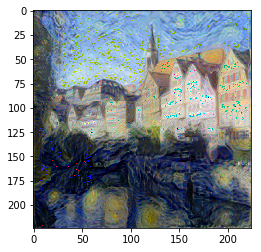

In [21]:
img = sess.run(opt_img) / 255
plt.imshow(np.squeeze(img))
plt.show()